# Language Models

In this session we will learn the following:
- How to use NLTK to build n-gram Language Models
- Build a Recurrent Neural Language Model
- Apply Language Models to generation.

## Preliminary Steps

Make sure you have the latest NLTK version (3.4 or higher).
You can install NLTK using pip: pip install NLTK

The following examples will be using Python 3 syntax and conventions.
Once you have installed NLTK, you need to download the required corpora. Launch the Python interpreter and type:

In [ ]:
import nltk
nltk.download()

A new window should open, showing the NLTK Downloader. Next, select all-corpora to download.

NLTK provides many corpora covering different types of texts. We’ll work with the C-span corpus of state of the union and inaugural speeches by US presidents.

To access the corpora:

In [ ]:
from nltk.corpus import state_union
from nltk.corpus import inaugural


#To list all documents in a corpus, you can use the fileids() method:
inaugural.fileids()


In [130]:
#To access the content of a given document, you can use the raw(), words() and sents() methods as follows:
inaugural.raw('2009-Obama.txt')

'My fellow citizens:\n\nI stand here today humbled by the task before us, grateful for the trust you have bestowed, mindful of the sacrifices borne by our ancestors. I thank President Bush for his service to our nation, as well as the generosity and cooperation he has shown throughout this transition.\n\nForty-four Americans have now taken the presidential oath. The words have been spoken during rising tides of prosperity and the still waters of peace. Yet, every so often the oath is taken amidst gathering clouds and raging storms. At these moments, America has carried on not simply because of the skill or vision of those in high office, but because We the People have remained faithful to the ideals of our forbearers, and true to our founding documents.\n\nSo it has been. So it must be with this generation of Americans.\n\nThat we are in the midst of crisis is now well understood. Our nation is at war, against a far-reaching network of violence and hatred. Our economy is badly weakened

In [79]:
inaugural.words('1793-Washington.txt')


['Fellow', 'citizens', ',', 'I', 'am', 'again', ...]

In [80]:
inaugural.sents('2021-Biden.txt')

[['Chief', 'Justice', 'Roberts', ',', 'Vice', 'President', 'Harris', ',', 'Speaker', 'Pelosi', ',', 'Leader', 'Schumer', ',', 'Leader', 'McConnell', ',', 'Vice', 'President', 'Pence', ',', 'and', 'my', 'distinguished', 'guests', ',', 'and', 'my', 'fellow', 'Americans', ':', 'This', 'is', 'America', "'", 's', 'day', '.'], ['This', 'is', 'democracy', "'", 's', 'day', ',', 'a', 'day', 'of', 'history', 'and', 'hope', ',', 'of', 'renewal', 'and', 'resolve', '.'], ...]

## The LM Module: Basics

Since NLTK 3.4, the **lm** module allows to build language models.
First thing we need is to count types (words, bigrams, trigrams, etc.): we can do this in different ways, using Counter from the collections package or, more properly, by using NgramCounter from the lm module:


In [81]:
from nltk.util import ngrams
from nltk.lm import NgramCounter

let's count all unigrams (single words) in the State of the Union corpus (state_union):

In [82]:
text_unigrams = [ngrams(sent, 1) for sent in state_union.sents()]
#for tu in text_unigrams:
#    print(list(tu))
ngram_counts=NgramCounter(text_unigrams)
ngram_counts.N()

399829

be careful since the ngrams function produces a generator: once the ngrams are used, they are 'lost'.

You can look at the frequencies of a type (word) in a very simple way:

In [83]:
ngram_counts['the']

19191

In [84]:
ngram_counts.unigrams.most_common(2)

[('the', 19191), ('.', 17504)]

If you have matplotlib installed, it is possible to display a rank/frequency diagram by typing:

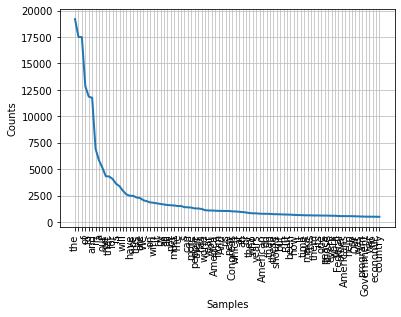

In [85]:
ngram_counts.unigrams.plot(90)

Example for bigrams:

In [86]:
text_bigrams = [ngrams(sent, 2) for sent in state_union.sents()]
ngram_counts=NgramCounter(text_bigrams)
ngram_counts[['the']]

FreqDist({'world': 645, 'Congress': 561, 'United': 401, 'American': 278, 'people': 237, 'Federal': 213, 'next': 189, 'past': 185, 'most': 179, 'future': 172, ...})

In [87]:
ngram_counts[['the']]['people']

237

Vocabulary objects allow to create a vocabulary from a set of types and a frequency threshold:

In [88]:
from nltk.lm import Vocabulary

vocab = Vocabulary(state_union.words(), unk_cutoff=2)
#The vocabulary will include all words that appear at least 2 times in the corpus.

vocab["America"]

1076

**Exercise 1**: Count the number of unigrams for each of the presidents in the inaugural dataset. Which one held the longest discourse? Which one the shortest one?

In [89]:
#YOUR CODE HERE
import numpy as np

def count_unigram(inaugural, text):
    text_unigrams = [ngrams(sent, 1) for sent in inaugural.sents(text)]
    #for tu in text_unigrams:
    #    print(list(tu))
    ngram_counts=NgramCounter(text_unigrams)
    return ngram_counts.N()

pres_inaug = inaugural.fileids() # to have the list of inaugural documents
count_ugram = [count_unigram(inaugural, text) for text in pres_inaug]

index_long_disc = np.argmax(count_ugram)
index_shortest_disc = np.argmin(count_ugram)

print("The longest discourse has been held by the President", pres_inaug[index_long_disc][5:][:-4], " and the shortest by ", pres_inaug[index_shortest_disc][5:][:-4])



The longest discourse has been held by the President Harrison  and the shortest by  Washington


**1.b)**: Count the number of different *types*. Which president used the "richest vocabulary" for his speech?

In [90]:
#YOUR CODE HERE

def count_vocab(inaugural, text):
    vocab = Vocabulary(inaugural.words(text)
, unk_cutoff=1)
    return len(vocab)
pres_inaug = inaugural.fileids() 
count_vocab_ = [count_vocab(inaugural, text) for text in pres_inaug]
index_max = np.argmax(count_vocab_)

print("The President", pres_inaug[index_max][5:][:-4] , " used the richest vocabulary for his speech")

The President Harrison  used the richest vocabulary for his speech


## Building a language model

Once we have the data we need to introduce padding to tell the model what the boundaries of the sentence are, and to calculate probabilities for the starting and the end of a sentence. Luckily, NLTK has a function that allows us to do it easily:

In [91]:
from nltk.lm.preprocessing import pad_both_ends
from nltk.util import bigrams

sentence=inaugural.sents('2009-Obama.txt')[0]

list(pad_both_ends(sentence, n=2))
list(bigrams(pad_both_ends(sentence, n=2))) #extract bigrams

[('<s>', 'My'),
 ('My', 'fellow'),
 ('fellow', 'citizens'),
 ('citizens', ':'),
 (':', '</s>')]

The module lm will need also a flattened list of symbols to build the vocabulary. We can do it with the following function:

In [92]:
from nltk.lm.preprocessing import flatten
list(flatten(pad_both_ends(sent, n=2) for sent in inaugural.sents('2009-Obama.txt')))


['<s>',
 'My',
 'fellow',
 'citizens',
 ':',
 '</s>',
 '<s>',
 'I',
 'stand',
 'here',
 'today',
 'humbled',
 'by',
 'the',
 'task',
 'before',
 'us',
 ',',
 'grateful',
 'for',
 'the',
 'trust',
 'you',
 'have',
 'bestowed',
 ',',
 'mindful',
 'of',
 'the',
 'sacrifices',
 'borne',
 'by',
 'our',
 'ancestors',
 '.',
 '</s>',
 '<s>',
 'I',
 'thank',
 'President',
 'Bush',
 'for',
 'his',
 'service',
 'to',
 'our',
 'nation',
 ',',
 'as',
 'well',
 'as',
 'the',
 'generosity',
 'and',
 'cooperation',
 'he',
 'has',
 'shown',
 'throughout',
 'this',
 'transition',
 '.',
 '</s>',
 '<s>',
 'Forty',
 '-',
 'four',
 'Americans',
 'have',
 'now',
 'taken',
 'the',
 'presidential',
 'oath',
 '.',
 '</s>',
 '<s>',
 'The',
 'words',
 'have',
 'been',
 'spoken',
 'during',
 'rising',
 'tides',
 'of',
 'prosperity',
 'and',
 'the',
 'still',
 'waters',
 'of',
 'peace',
 '.',
 '</s>',
 '<s>',
 'Yet',
 ',',
 'every',
 'so',
 'often',
 'the',
 'oath',
 'is',
 'taken',
 'amidst',
 'gathering',
 'cloud

There is also a convenience method called everygram_pipeline that produces the two at the same time – from the manual:
    
    padded_everygram_pipeline(order, text):
    Default preprocessing for a sequence of sentences.

    Creates two iterators:
    - sentences padded and turned into sequences of `nltk.util.everygrams`
    - sentences padded as above and chained together for a flat stream of words

    :param order: Largest ngram length produced by `everygrams`.
    :param text: Text to iterate over. Expected to be an iterable of sentences:
    Iterable[Iterable[str]]
    :return: iterator over text as ngrams, iterator over text as vocabulary data

For example:

In [93]:
from nltk.lm.preprocessing import padded_everygram_pipeline

train, vocab = padded_everygram_pipeline(3, inaugural.sents())


Having prepared our data we are ready to start training a model. As a simple example, let us train a Maximum Likelihood Estimator (MLE).

In [94]:
from nltk.lm import MLE
lm = MLE(3) #the parameter is the highest n-gram order for our model. We consider up to trigrams in this example 

lm.fit(train, vocab) #fit with the data. May take a while

We can verify frequencies in the same way as we did with the NgramCounter:

In [95]:
lm.counts['America']

240

In [96]:
lm.counts[['bless']]['America']

5

The score function returns the probability of observing the given word:

In [97]:
#m.score('America')
#lm.score('America', ['bless']) #or the probability of observing a word given the previous word
lm.score('America', ['God', 'bless'])

0.29411764705882354

Note that these probabilities are not smoothed since we used a MLE model. For better results, models with smoothing are available:
-	nltk.lm.Lidstone (requires the gamma parameter to increase scores)
-	nltk.lm.Laplace (add 1)
-	nltk.lm.KneserNeyInterpolated

**Exercise 2**: Build a language model from the **state_union** dataset. Verify the probabilities for the words "America", "the" and "jobs", first without smoothing and then using Laplace smoothing (warning: it may take a certain time).

In [98]:
#YOUR CODE HERE
from nltk.lm import Laplace

train, vocab = padded_everygram_pipeline(3, state_union.sents())
# Without smoothing

lm_MLE = MLE(3) #the parameter is the highest n-gram order for our model. We consider up to trigrams in this example 
lm_MLE.fit(train, vocab) 
print("The probability for non smoothing model(MLE):\n")
print("\"America\":",lm_MLE.score("America"),"\n","\"the\":",lm_MLE.score("the"),"\n","\"jobs\":",lm_MLE.score("jobs"),"\n" )

# With smoothin

train, vocab = padded_everygram_pipeline(3, state_union.sents())
lm_Laplace = Laplace(3)
lm_Laplace.fit(train, vocab)
print("The probability for smoothing model(Laplace):\n")
print("\"America\":",lm_Laplace.score("America"),"\n","\"the\":",lm_Laplace.score("the"),"\n","\"jobs\":",lm_Laplace.score("jobs"),"\n" )

The probability for non smoothing model(MLE):

"America": 0.0022823059774781367 
 "the": 0.040706072503515725 
 "jobs": 0.0005875453120459516 

The probability for smoothing model(Laplace):

"America": 0.0022158487708931703 
 "the": 0.039486137057550344 
 "jobs": 0.0005719646780949873 



## Evaluating language models: perplexity

Perplexity is a measure of how well does your model approximate true probability distribution behind data. __Smaller perplexity = better model__.

To compute perplexity on one sentence, use:
$$
    {\mathbb{P}}(w_1 \dots w_N) = 2^{-\frac{1}{N} \left( \sum_{t=1}^N \log P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)},
$$


**Exercise 3**: We would like to create a function that calculates the perplexity on a given test set, made of multiple sentences, returning their average. Complete the following code to calculate the perplexity as defined above

Hint: you can obtain the log-probabilities from the model with the function lm.logscore(...). To help, we include the conversion of the input sentences into sequences of n-grams, including the start and the end of the sentences (special symbols \<s> and \</s> )

In [99]:
from nltk.util import ngrams
import numpy as np

def perplexity(lm, sents, n, min_logprob=np.log(10 ** -50.)):
    """
    :param sents: a list of sentences (each sentence a list of words)
    :param n: the size of n-grams for which to compute the perplexity. This cannot exceed the size used for the construction of the LM
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprob, set it equal to min_logprob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    """
    
    test_data = [nltk.ngrams(t, n, pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in sents]
    prp=[]

    for test in test_data:
        #YOUR CODE
        p = 1
        tmp = np.mean(np.array([np.log2(lm.score(n_gram[-1], n_gram[:-1])) if np.log2(lm.score(n_gram[-1], n_gram[:-1])) >min_logprob else min_logprob for n_gram in test]))
        
        prp.append(2**(-1.0*tmp))
        
    return np.mean(prp)


**Exercise 3.a**: Evaluate your perplexity function on the *inaugural* dataset and test for $n \in \{1,2,3,4\}$. What do you obtain? Can you explain the result?

In [100]:
#example
sents=inaugural.sents()

#perplexity(lm, sents, 3)
#YOUR CODE
for n in {1,2,3,4}:
    train, vocab = padded_everygram_pipeline(n, sents)
    lm = MLE(n)
    lm.fit(train, vocab)
    print("The perplexity for n =", n,"is ",perplexity(lm, sents, n))

The perplexity for n = 1 is  686.1492117799304
The perplexity for n = 2 is  35.35814794552136
The perplexity for n = 3 is  4.383848601379747
The perplexity for n = 4 is  1.8108341298073785


We observe that the perplexity decrease with increasing of n. it's not a surprise because, the larger the context, the greater the probability of deducing the next word and the lower the perplexity.
example:
- with the context 'The' it is unlikely to deduce the continuation but,
- with the context 'God bless' it is very likely that the following word represents an entity such as a country.

## Generation

Finally, we are using the model to generate language. The key function is called **generate**, always in the lm interface

    def generate(self, num_words=1, text_seed=None, random_seed=None):
        Generate words from the model.

        :param int num_words: How many words to generate. By default 1.
        :param text_seed: Generation can be conditioned on preceding context.
        :param random_seed: If provided, makes the random sampling part of
        generation reproducible.
        :return: One (str) word or a list of words generated from model.
 
**Exercise 4**: Generate 10 sentences, each composed by 10 words, using the prompt "I shall", and calculate the average perplexity on the generated set. Compare this value to the value obtained on the *inaugural* dataset. Try for 2- and 3- grams.

What can you conclude about the quality of the generated text (both on the basis of the values you obtained and your personal judgment)?

In [103]:
lm.generate(10, ["I", "shall"])

#YOUR CODE HERE
sents = [lm.generate(10, ["I", "shall"]) for _ in range(10)]
for sent in sents :
  print(sent)
#
#
for n in {2, 3}:
  train, vocab = padded_everygram_pipeline(n, sents)
  lm = MLE(n)
  lm.fit(train, vocab)
  print(perplexity(lm, sents, n))

['presently', 'urge', 'upon', 'a', 'new', 'Congress', 'in', 'special', 'session', 'detailed']
['not', 'seek', 'to', 'intimidate', ',', 'but', 'it', 'will', 'in', 'no']
['have', 'the', 'most', 'solemn', 'one', 'to', '"', 'preserve', ',', 'protect']
['expect', 'those', 'whom', 'I', 'may', 'appoint', 'to', 'justify', 'their', 'selection']
['endeavor', 'to', 'preserve', 'it', ',', 'so', 'far', 'from', 'being', 'weakened']
['swear', 'to', 'the', 'best', 'of', 'my', 'ability', 'and', 'within', 'my']
['keep', 'steadily', 'in', 'view', 'the', 'limitations', 'as', 'well', 'as', 'all']
['endeavor', 'to', 'select', 'men', 'whose', 'diligence', 'and', 'talents', 'will', 'insure']
['conform', 'to', 'these', 'views', ',', 'as', 'I', 'believe', ',', 'become']
['look', 'to', 'the', 'condition', 'of', 'our', 'country', 'in', 'relation', 'to']
1.9547638970464714
1.225935895325374


# Neural Language Models

The following script contains a demonstration of how to create a neural language model using Recurrent NN (in this case, LSTM) with Keras. Word vectors are one-hot representations. This script has an embedded training text, which is too short to produce reliable results (as you will probably notice).

In [104]:
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku
import numpy as np

tokenizer = Tokenizer()

def dataset_preparation(data):
    #the purpose of this function is to transform the text in a format that can be handled by the model
    corpus = data.lower().split("\n")
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    input_sequences = []
    for line in corpus: #process corpus one line at a time
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len, total_words

def create_model(predictors, label, max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    model.add(Embedding(total_words, 10, input_length=input_len)) #Input Layer : Takes the sequence of words as input
    model.add(LSTM(150)) #LSTM Layer : Computes the output using LSTM units.
    model.add(Dropout(0.5)) #Dropout Layer : A regularisation layer which randomly turns-off the activations of some neurons in the LSTM layer. It helps in preventing over fitting.
    model.add(Dense(total_words, activation='softmax')) #Output Layer : Computes the probability of the best possible next word as output
    
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(predictors, label, epochs=500, verbose=1)
    return model


The following cell has some text that is used to train the model; use the short text for testing, and the 10 discourses (initially commented) from the inaugural dataset for the final experiments. If this takes too long, you can reduce the number of epochs above.

In [126]:
data = """The cat and her kittens
They put on their mittens,
To eat a Christmas pie.
The poor little kittens
They lost their mittens,
And then they began to cry.
O mother dear, we sadly fear
We cannot go to-day,
For we have lost our mittens.
If it be so, ye shall not go,
For ye are naughty kittens.
The three little kittens, they found their mittens,
And they began to cry,
Oh, mother dear, see here, see here,
For we have found our mittens.
Put on your mittens, you silly kittens,
And you shall have some pie.
Purr, purr, purr,
Oh, let us have some pie.
The three little kittens,
they washed their mittens,
And hung them out to dry,
Oh, mother dear, do you not hear,
That we have washed our mittens?
What, washed your mittens,
then you're good kittens,
But I smell a rat close by.
Meow, meow, meow,
We smell a rat close by."""

#data = '\n'.join([' '.join(s) for s in inaugural.sents()[:10]])

X, Y, msl, total_words = dataset_preparation(data)
model = create_model(X, Y, msl, total_words)

Epoch 1/500
5/5 [==============================] - 2s 18ms/step - loss: 4.2897
Epoch 2/500
5/5 [==============================] - 0s 17ms/step - loss: 4.2839
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 4.2780
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 4.2729
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 4.2634
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 4.2505
Epoch 7/500
5/5 [==============================] - 0s 16ms/step - loss: 4.2248
Epoch 8/500
5/5 [==============================] - 0s 15ms/step - loss: 4.1819
Epoch 9/500
5/5 [==============================] - 0s 15ms/step - loss: 4.1160
Epoch 10/500
5/5 [==============================] - 0s 15ms/step - loss: 4.0807
Epoch 11/500
5/5 [==============================] - 0s 15ms/step - loss: 4.0346
Epoch 12/500
5/5 [==============================] - 0s 22ms/step - loss: 3.9996
Epoch 13/500
5/5 [==============================]

### Generating with Temperature

As seen in the course, temperature can be used to tune the creativity of the model.

In the example below, we are not using temperature for sampling as the generate_text function always returns the most probable item.

As the model output are probabilities and not the logits (the softmax has been already applied), we use a trick to calculate the temperature on the final result: we use log to reverse the softmax operation and get logit-like values:

$$e^{(log(a)/T)} = a^{(1/T)}$$

**Exercise 5**: Modify the generate_text function to use temperatures to sample and test the results with temperature temp=2 and temp 0.2. Hint: you can use the function np.random.choice(...) to sample, use as parameters the list of indices of words and as p the probabilities with temperature

In [127]:
def generate_text(seed_text, next_words, max_sequence_len, model, temp=0):
    for j in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=
                             max_sequence_len-1, padding='pre')
        #here we obtain the index of the predicted word
        #note that model.predict(...) returns the probabilities associated to the words
        if temp==0: #if Temperature == 0, then return the most probable token
            predicted = np.argmax(model.predict(token_list), axis=-1)
        else:
            probs=model.predict(token_list)
            #YOUR CODE HERE
            prob = probs[0] #'prob' must be 1-dimensional
            prob = prob**(1/temp)/(np.sum(prob**(1/temp)))
            predicted = np.random.choice(a = [0]+list(tokenizer.index_word.keys()),replace = True, size = 1, p = prob)
            #Hint: predicted = np.random.choice(...)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            #we look for the index in the dictionary created by the tokenizer, then we get the word
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text



In [120]:
text = generate_text("rich little", 20, msl, model, 0.2)
print(text)

1/1 [==============================] - 0s 21ms/step
rich little mother we we sadly fear pie pie hear hear hear have began have kittens mittens silly kittens have hear have


### Alternative sampling strategies

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

**Exercise 6**: Implement a generate_with_nucleus_sampling function to use the nucleus sampling strategy. Compare (qualitatively) the results obtained with nucleus=0.9 and nucleus=0.3.

In [124]:
def generate_with_nucleus_sampling(seed_text, next_words, max_sequence_len, model, nucleus=0):
    for j in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=
                             max_sequence_len-1, padding='pre')
        #here we obtain the index of the predicted word
        #note that model.predict(...) returns the probabilities associated to the words
        if nucleus==0: #if nucleus == 0, then return the most probable token
            predicted = np.argmax(model.predict(token_list), axis=-1)
        else:
            probs=model.predict(token_list)
            #YOUR CODE
            p_sort = np.sort(probs[0,:])[::-1]
            p_argsort = np.argsort(probs[0,:])[::-1]
            i = 0
            events = []
            sum_p_sort = 0
            prob = []
            while(sum_p_sort < nucleus):
                sum_p_sort += p_sort[i]
                prob.append(p_sort[i])
                events.append(p_argsort[i])
                i += 1
            prob = [elt/sum(prob) for elt in prob]
            predicted = np.random.choice(a = events, size = 1,replace = True, p = prob)
            #predicted = ...

        output_word = ""
        for word, index in tokenizer.word_index.items():
            #we look for the index in the dictionary created by the tokenizer, then we get the word
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [125]:
text = generate_with_nucleus_sampling("rich little", 20, msl, model, 0.9)
print(text)
text = generate_with_nucleus_sampling("rich little", 20, msl, model, 0.6)
print(text)


1/1 [==============================] - 0s 21ms/step
rich little it be be ye ye ye their go good kittens shall have have washed hear mittens pie silly kittens have
1/1 [==============================] - 0s 22ms/step
rich little mother mother we we sadly fear pie hear hear hear pie kittens cry have some pie pie pie hear kittens


## Generation using GPT-2

The following script uses a **pre-trained** GPT-2 model to generate texts. This model has been trained on a vast set of documents scraped from the web.

You can use this script to produce a text based on an excerpt from a discourse in a database.

**Exercise 7**: Run this script and observe the result. Does the result look like an US inaugural or state of the union address? Can you imagine why?


In [129]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Encode a text inputs
text = "I stand here today humbled by the task before us"

indexed_tokens = tokenizer.encode(text)

# Convert indexed tokens in a PyTorch tensor
tokens_tensor = torch.tensor([indexed_tokens])

# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set the model in evaluation mode to deactivate the DropOut modules
model.eval()

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]

encoded_prompt = tokenizer.encode(text, add_special_tokens=False, return_tensors="pt")
encoded_prompt = encoded_prompt.to(torch.device("cpu"))

output_sequences = model.generate(
    input_ids=encoded_prompt,
    max_length=200, #number of tokens that will be produced (includes seed)
    temperature=0.9, #regulates "creativity of the model" - 1.0 default
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0, #default values
    do_sample=True,
)

# Batch size == 1. to add more examples please use num_return_sequences > 1
generated_sequence = output_sequences[0].tolist()
text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)

print(text)


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I stand here today humbled by the task before us and humbled by the dedication of those who care about you. We appreciate your opportunity to help the millions of families that are grieving the loss of your loved one.

We are grateful to you for your steadfast support. We invite you to join us in calling upon you to stand with us at this difficult time.

Your continued efforts in the community are what we can do for you. We are grateful for your continued involvement in the community. We are grateful for your support for our families. We welcome you to join us in growing the efforts of the Child Protective Services Department at the Department of Children and Families.

You are looking forward to helping us.

Please take a moment to read your City Council address to your elected representatives. You know that we are waiting for them to speak and we appreciate that.

Q. Thank you. A. Thank you.

Q. Thank you.

Q


The generated text start like 2009-obama.txt (US inaugural). There is a coherence in the construction of sentences. This similarity can be linked to the fact that the neural network was trained on a huge dataset that may have included the discourse we studied earlier.